In [1]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import the self-build blocks
%pwd
# from lightunet import LightUnet


'/home/qiao/dev/giao/works/detecting/segmentation/unet34'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
path = Path('/home/qiao/dev/giao/data/Google2020')

path_img = path/'image/'
path_label = path/'mask'
codes = ['Smoke', 'Flame_Spot', 'Cloud', 'Person', 'Background']
path_img

Path('/home/qiao/dev/giao/data/Google2020/image')

In [5]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/data/Google2020/image/0027.png


In [6]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/data/Google2020/mask/0027.png


In [7]:
img = Image.open(fnames[0])
img.show()

In [8]:
img = Image.open(lbl_names[0])
img.show()

In [9]:
get_y_fn = lambda x: path_label/f'{x.name}'
defaults.use_cuda = True

In [10]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 1,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((400, 400))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [11]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [12]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

/home/qiao/anaconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qiao/anaconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [14]:
# learn.model

SuggestedLRs(valley=0.00015848931798245758)

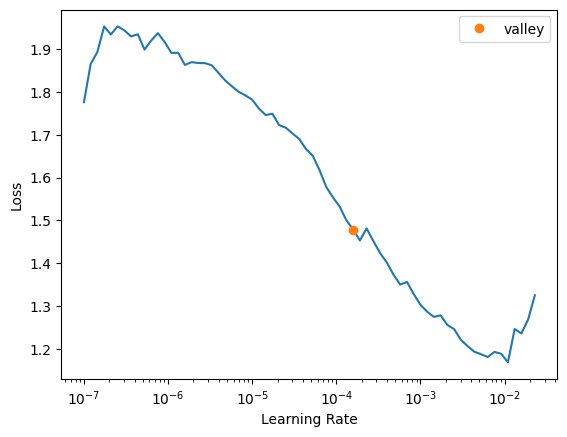

In [15]:
# learn.lr_find(stop_div=False, num_it=10)
learn.lr_find()

In [16]:
lr = 1.5e-4
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,1.407681,1.029467,0.477871,00:04
1,0.969159,0.583718,0.753218,00:04
2,0.817169,0.684423,0.824276,00:04
3,0.732314,0.563259,0.797673,00:04
4,0.659365,0.628538,0.728150,00:04
5,0.614671,0.550787,0.775116,00:04
6,0.604912,0.524810,0.832420,00:04
7,0.550611,0.545375,0.801290,00:04
8,0.507794,0.460979,0.823377,00:04
9,0.465342,0.482356,0.798580,00:04


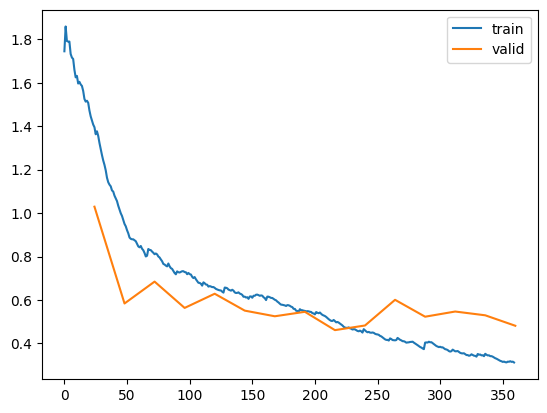

In [17]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [18]:
learn.save('stage-1_20230929')
learn.load('stage-1_20230929')

SuggestedLRs(valley=5.248074739938602e-05)

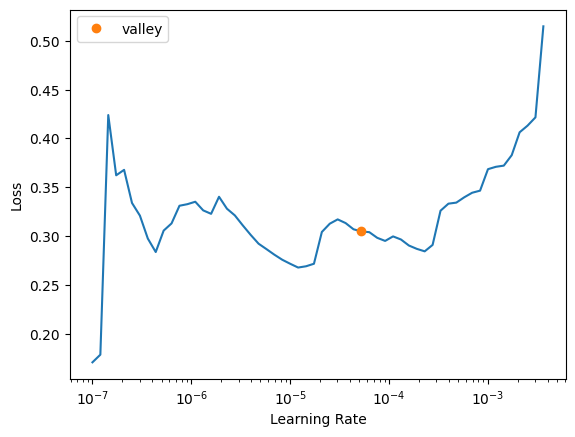

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
lr_max = 5e-5

In [21]:
learn.fit_one_cycle(7, lr_max)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.283902,0.520385,0.798669,00:05
1,0.328532,0.552166,0.785230,00:05
2,0.321458,0.436335,0.823921,00:05
3,0.299102,0.460682,0.827794,00:05
4,0.280542,0.445495,0.826294,00:05
5,0.255404,0.446650,0.829512,00:05
6,0.236979,0.457443,0.819556,00:05


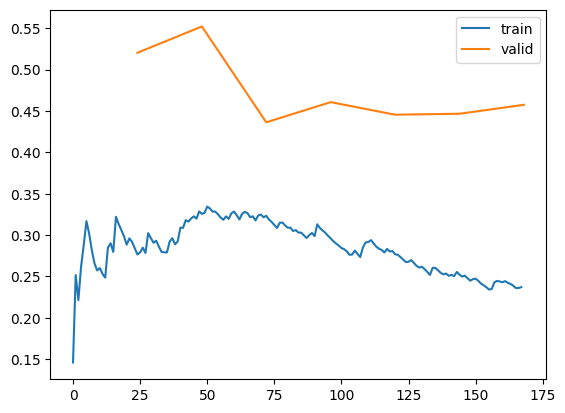

In [22]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/data/Google2020/image/models/U-res34_20230929.pth')

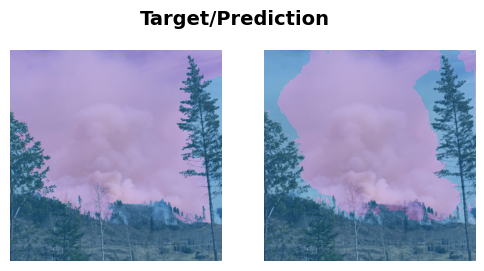

In [23]:
learn.show_results()
learn.save('U-res34_20230929')

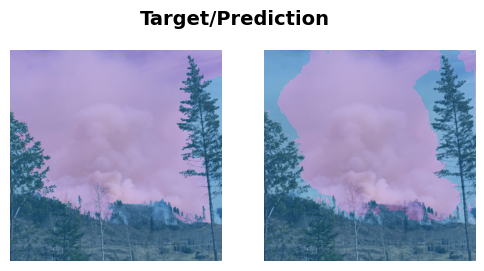

In [24]:
# learn.show_results()
learn.load('U-res34_20230929')
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [30]:
img = Image.open('/home/qiao/dev/giao/data/videos/20230926/frames/frame_0.png').resize((255, 255))
img.show()

In [27]:
img = PILImage(img)

In [28]:
learn.load('U-res34_20230929')
# learn.load('attunet')

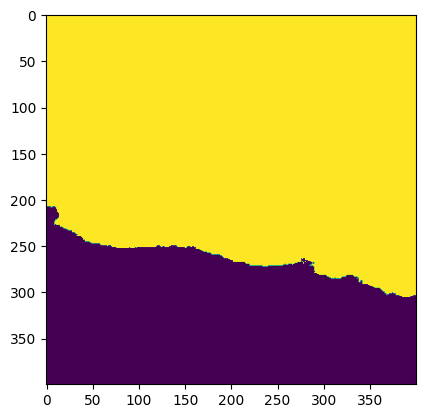

In [29]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[0]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)